<a href="https://colab.research.google.com/github/Imartinezcuevas/k_brazos_MC_OL/blob/main/bandit_experiment_ComparacionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo Epsilon-Greedy vs Gradiente de Preferencias en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de los algoritmos Epsilon-Greedy y Gradiente de Preferencias en un problema de k-armed bandit.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

# Introducción
En este estudio, nos enfocamos en realizar una comparación exhaustiva del rendimiento de varios algoritmos ampliamente utilizados para resolver el problema de los k-brazos: Epsilon-Greedy, UCB1, UCB2 y Gradiente de Preferencias. Estos algoritmos representan diferentes enfoques para el equilibrio entre exploración y explotación, un desafío fundamental en la toma de decisiones secuenciales.

Dentro de la familia de algoritmos de ascenso del gradiente, hemos observado que el algoritmo de Gradiente de Preferencias supera significativamente a la estrategia Softmax, que muestra un rendimiento deficiente al no alcanzar la recompensa óptima en nuestras pruebas iniciales. Por lo tanto, centraremos nuestro análisis en Gradiente de Preferencias.

El objetivo principal de este estudio es analizar y comparar el rendimiento de estos cuatro algoritmos bajo diversas condiciones experimentales. Para ello, evaluaremos su desempeño mediante:

1. **Comparación directa entre los cuatro algoritmos**: Seleccionaremos los parámetros óptimos de cada algoritmo, basados en estudios individuales previos, y compararemos su rendimiento en entornos controlados.

2. **Evaluación con diferentes cantidades de brazos**: Investigaremos cómo el número de brazos afecta el rendimiento de cada algoritmo, explorando tanto escenarios con pocos brazos como aquellos con muchos.

3. **Estudio de la influencia de las distribuciones de recompensa**: Modificaremos las distribuciones subyacentes de las recompensas para analizar la robustez y adaptabilidad de cada algoritmo ante diferentes escenarios.

A través de estos experimentos, buscamos obtener una comprensión profunda de las fortalezas y debilidades de cada algoritmo, identificar en qué escenarios específicos cada uno sobresale y proporcionar recomendaciones prácticas sobre su aplicabilidad en problemas reales de toma de decisiones secuenciales.

## Preparación del entorno

In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/k_brazos_MC_OL.git
!cd k_brazos_MC_OL/

Cloning into 'k_brazos_MC_OL'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 233 (delta 122), reused 130 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (233/233), 25.39 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy, GradientePreferencias, UCB1, UCB2
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_MC_OL/src']


## Bucle experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    # Para almacenar selecciones y recompensas promedio de cada brazo por algoritmo
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Número de selecciones por brazo
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Suma de recompensas por brazo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)
        # Obtener la recompensa esperada óptima.
        optimal_reward = current_bandit.get_expected_value(optimal_arm)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.
                regrets[idx, step] = optimal_reward*(step+1) - total_rewards_per_algo[idx] # Acumular el regret en la matriz regrets para el algoritmo idx en el paso step.


                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm",
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Registrar número de selecciones y recompensas por brazo
                arm_counts[idx, chosen_arm] += 1
                arm_rewards[idx, chosen_arm] += reward


    rewards /= runs
    regrets /= runs  # Calcular el promedio del regret acumulado
    arm_avg_rewards = np.divide(arm_rewards, arm_counts, out=np.zeros_like(arm_rewards), where=arm_counts != 0)
    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    return rewards, optimal_selections, regrets, arm_counts, arm_avg_rewards

# Análisis comparativo

### Comparación entre algoritmos
Las variantes a estudiar son las siguiente:
* Para Gradiente de Preferencias: alpha = 0.3
* Para Epsilon-Greedy: epsilon = 0.1
* Para UCB2: alpha=1
* UCB1

Cosas a estudiar:
* Velocidad de convergencia de cada algoritmo.
* Comparar la recompensa acumulada y regret alcanzados por cada uno.
* Observar la capacidad de cada algoritmo para identificar y seleccionar el brazo óptimo.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.3), UCB2(k=k, alpha=1), UCB1(k=k)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### Recompensa promedio

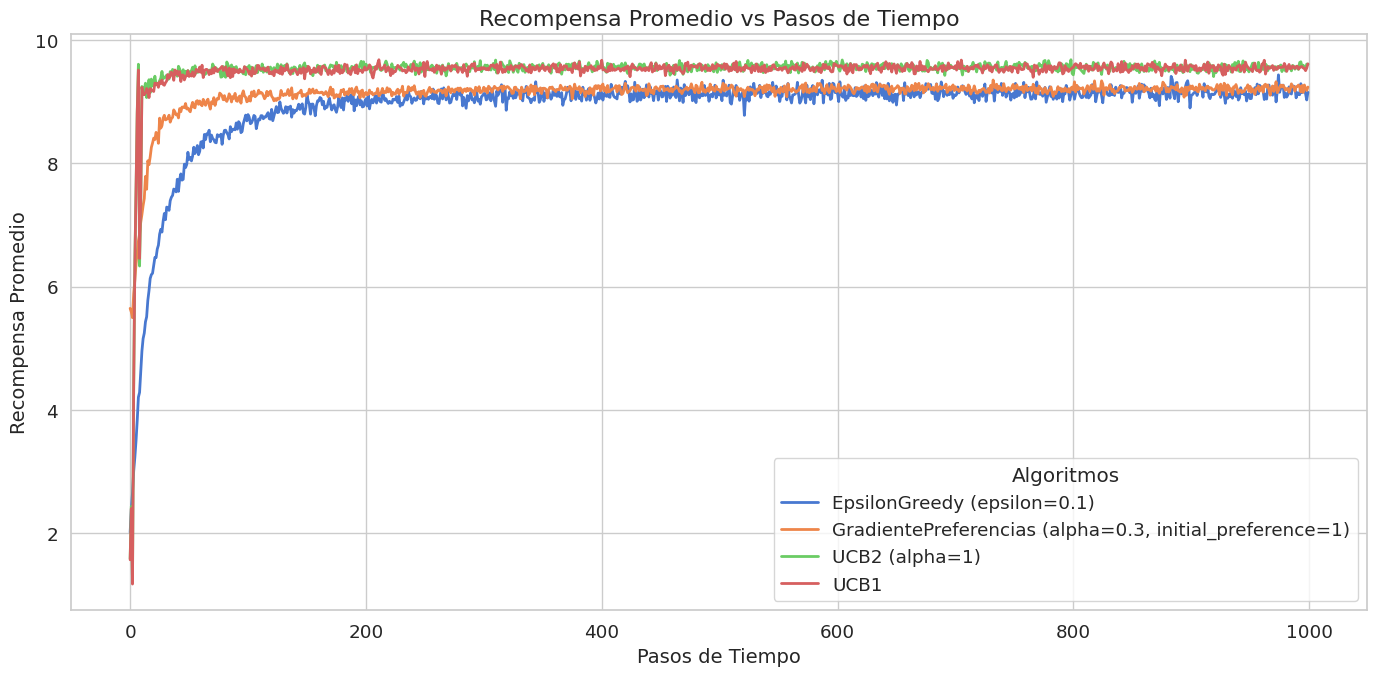

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Este algoritmo muestra la convergencia más lenta, tardando aproximadamente 200 pasos de tiempo en estabilizarse.
  * La recompensa promedio alcanzada es la más baja de los cuatro algoritmos, cercana a 9.
  * Esto sugiere que la exploración constante (epsilon=0.1) retrasa la explotación óptima, resultando en un aprendizaje más lento y una recompensa final menor.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Converge mucho más rápido que Epsilon-Greedy, estabilizándose alrededor de los 40-50 pasos de tiempo.
  * Alcanza una recompensa promedio ligeramente superior a Epsilon-Greedy.
  * Esto indica que su estrategia de ajustar las preferencias basadas en el gradiente permite una explotación más eficiente de las recompensas, especialmente con una tasa de aprendizaje (alpha) relativamente alta.

3. **UCB1 (roja) y UCB2 (verde):**
  * Ambos algoritmos muestran una convergencia extremadamente rápida, alcanzando la recompensa promedio más alta, aproximadamente 9.56, en muy pocos pasos de tiempo.
  * Esto demuestra la eficacia de los algoritmos UCB (Upper Confidence Bound) en equilibrar la exploración y la explotación.
  * UCB1 y UCB2 utilizan intervalos de confianza para seleccionar las acciones, lo que les permite identificar rápidamente las mejores opciones y maximizar la recompensa. La similitud en los resultados sugiere que, en este escenario, ambos algoritmos funcionan de manera muy similar.

**Conclusiones**
  * Los algoritmos UCB1 y UCB2 demuestran un rendimiento superior, logrando una convergencia rápida y la recompensa promedio más alta. Esto resalta su efectividad en entornos donde se busca maximizar la recompensa rápidamente.
  * Gradiente de Preferencias con alpha=0.3 muestra un buen equilibrio entre exploración y explotación, ofreciendo una convergencia rápida y una recompensa promedio decente.
  * Epsilon-Greedy con epsilon=0.1, aunque simple, resulta en un aprendizaje lento y una recompensa promedio menor, lo que indica que una exploración excesiva puede ser perjudicial en este escenario.

#### Regret acumulado

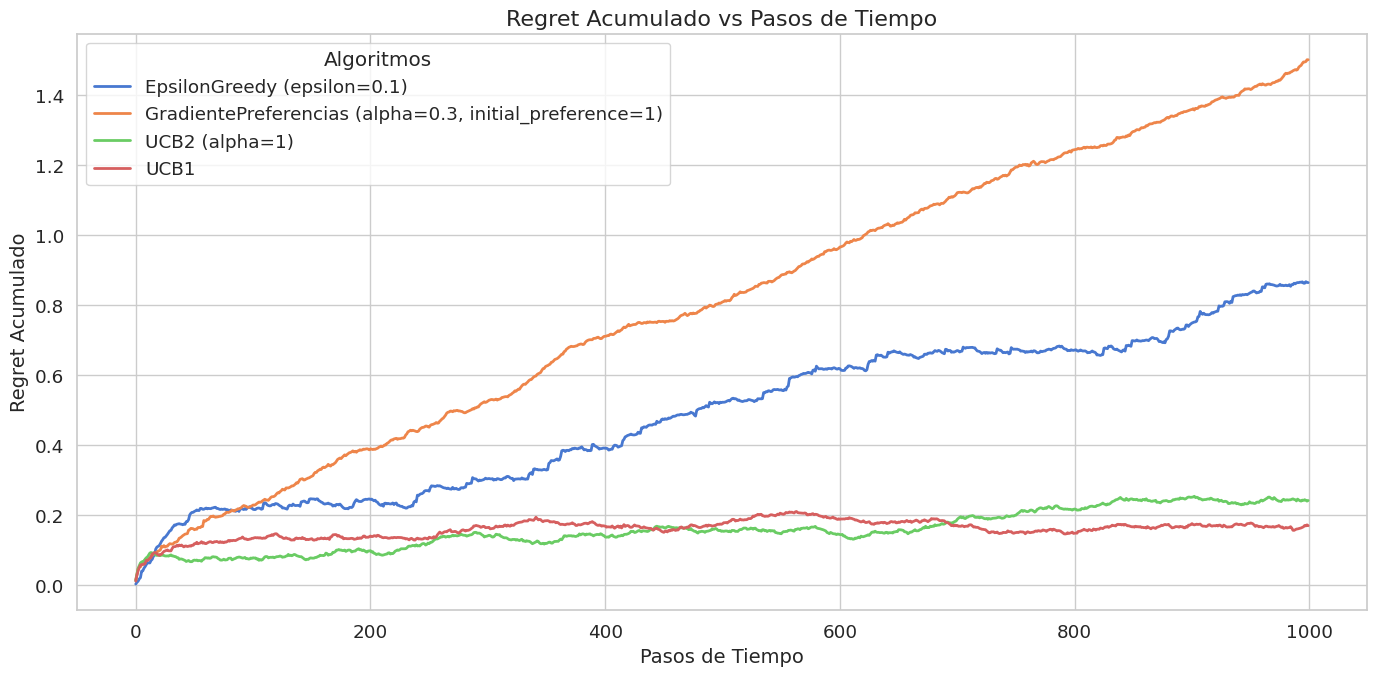

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
  1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Muestra una subida inicial rápida hasta 0.2 en las primeras iteraciones, lo que indica una exploración inicial significativa.
  * Después de la subida inicial, el regret acumulado se mantiene relativamente estable por un tiempo, antes de volver a aumentar con una pendiente suave.
  * Esto refleja el equilibrio entre exploración y explotación de Epsilon-Greedy, con una pérdida acumulada moderada a largo plazo.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Muestra el mayor regret acumulado, con una línea que asciende casi linealmente desde 0 hasta 1.4.
  * Esto indica que Gradiente de Preferencias tiene dificultades para identificar y explotar las mejores acciones, resultando en una pérdida acumulada significativa.

3. **UCB1 (roja) y UCB2 (verde):**
  * Ambos algoritmos muestran el menor regret acumulado, manteniéndose cerca de 0.2 a lo largo del tiempo.
  * Esto indica que los algoritmos UCB logran identificar y explotar las mejores acciones de manera eficiente, minimizando la pérdida de recompensa.

**Conclusiones**
  * Los algoritmos UCB (UCB1 y UCB2) demuestran un rendimiento superior en términos de regret acumulado, minimizando la pérdida de recompensa..
  * Epsilon-Greedy logra un equilibrio razonable, con una pérdida acumulada moderada.

#### Porcentaje de selección del brazo óptimo

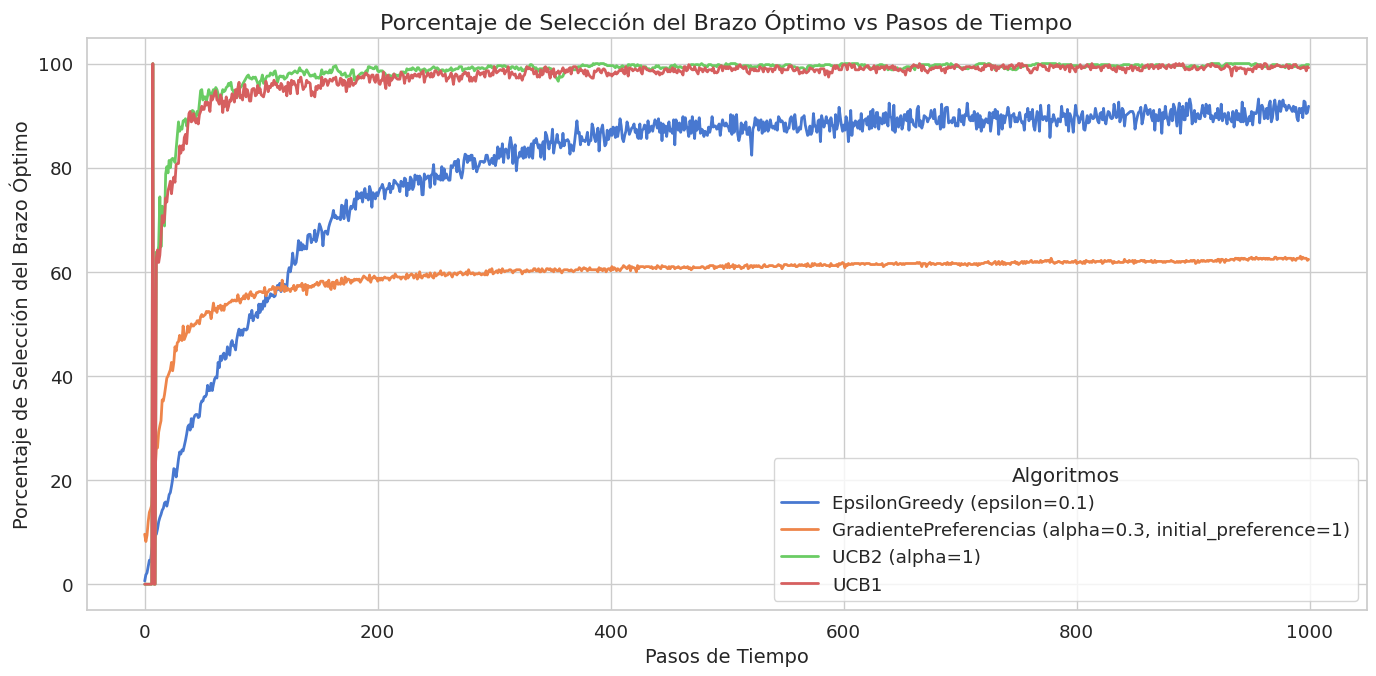

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Observaciones principales**
 1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Tarda aproximadamente 400 pasos de tiempo en alcanzar un porcentaje de selección del brazo óptimo cercano al 90%.
  * Esto refleja la exploración constante de Epsilon-Greedy, que retrasa la explotación óptima.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Muestra una convergencia similar a los algoritmos UCB, pero con una selección máxima del brazo óptimo de alrededor del 60%.
  * Esto demuestra que aunque aprende cual es el mejor brazo, no lo explota de la misma manera que los algoritmos UCB.

3. **UCB1 (roja) y UCB2 (verde):**
  * Ambos algoritmos muestran un comportamiento similar y eficiente.
  * Se mantienen cerca del 100% hasta el final, lo que demuestra su capacidad para explotar la acción óptima de manera consistente.

**Conclusiones**
* Los algoritmos UCB (UCB1 y UCB2) demuestran una capacidad superior para identificar y explotar el brazo óptimo.
* Esta métrica, muestra claramente la diferencia de explotación entre los algoritmos.

### Conclusión

Sin duda, UCB1 y UCB2 son los mejores algoritmos en este experimento. Ambos alcanzan la recompensa más alta (~9.56), tienen el menor regret acumulado (~0.2) y seleccionan consistentemente el brazo óptimo (~100% del tiempo). Su enfoque basado en intervalos de confianza permite una exploración eficiente y una rápida convergencia hacia la mejor opción.

Una observación interesante es el mal desempeño del Gradiente de Preferencias. Este algoritmo acumula el mayor regret (~1.4) y solo selecciona el brazo óptimo en un 60% de las ocasiones, lo que sugiere que no es capaz de explotar completamente la mejor opción. Esto podría deberse a que la actualización de preferencias basada en el gradiente no es suficientemente agresiva para maximizar la recompensa en este entorno.

## Comparación entre número de brazos
Para comparar los algoritmos en escenarios con diferentes niveles de complejidad. Para ello en este apartado se estudiará como el número de brazos afecta en la capacidad de convergencia y la eficiencia de ambos algoritmos.

Los objetivos son:
* Determinar como el rendimiento de los algoritmos se ve afectado al aumentar el número de brazos.
* Observar como la velocidad de convergencia varía en función del número de brazos.

Se realizarán experimentos variando el número de brazos en el siguiente rango $[10, 30]$.

#### K = 20

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 20  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.3), UCB2(k=k, alpha=1), UCB1(k=k)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 20 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

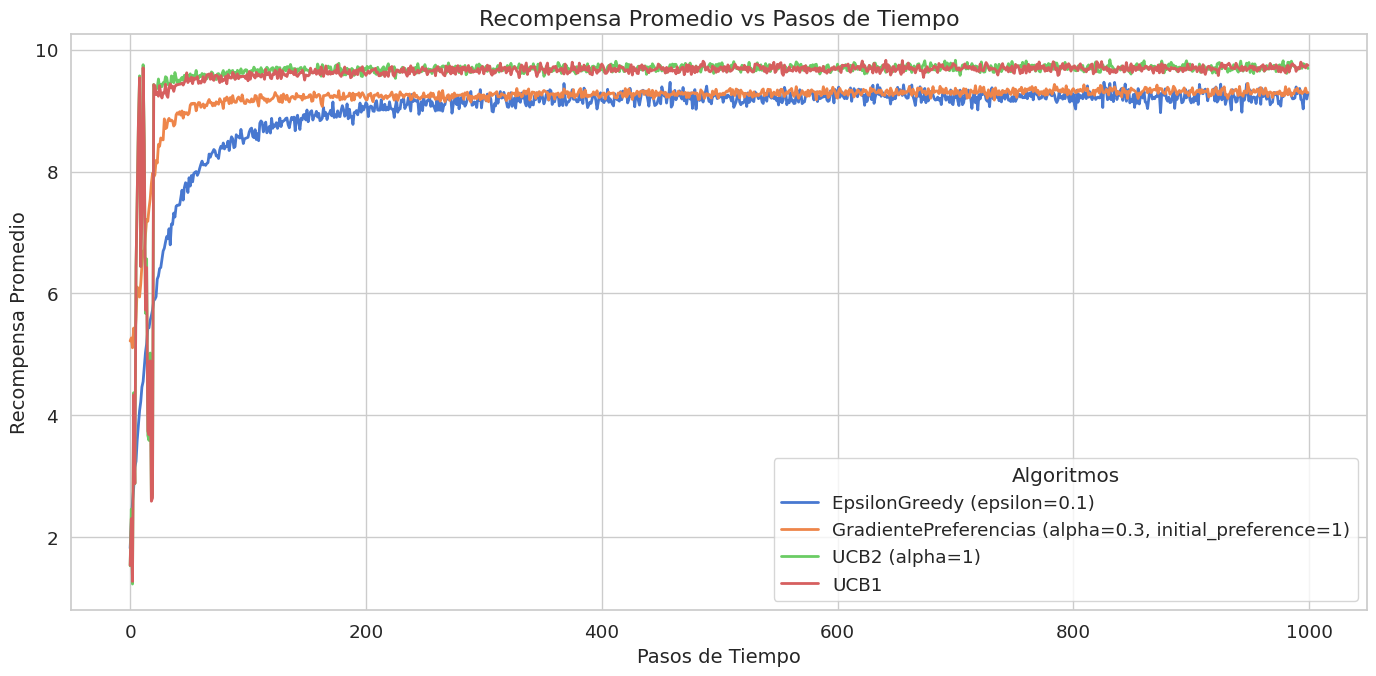

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * El comportamiento del algoritmo se mantiene similar al escenario con menos brazos.
  * Continúa mostrando una convergencia lenta, tardando alrededor de 200 pasos de tiempo en estabilizarse.
  * La recompensa promedio alcanzada permanece relativamente baja, lo que indica que la exploración constante sigue siendo un factor limitante.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Al igual que Epsilon-Greedy, Gradiente de Preferencias mantiene un comportamiento similar.
  * La recompensa promedio se mantiene similar.

3. **UCB1 (roja) y UCB2 (verde):**
  * En este escenario con 20 brazos, los algoritmos UCB muestran un comportamiento significativamente diferente al inicio.
  * Se observa una alta volatilidad en la recompensa promedio durante los primeros pasos de tiempo. Esto se debe a que, con más brazos, los algoritmos necesitan explorar un espacio de acción mucho mayor para identificar las mejores opciones.
  * Esto demuestra la capacidad de los algoritmos UCB para adaptarse a entornos con mayor complejidad, aunque requieren un período de exploración inicial más extenso.

**Conclusiones**
  * El aumento en el número de brazos afecta principalmente a los algoritmos UCB, introduciendo un período de exploración inicial más prolongado y volátil.
  * A pesar de la volatilidad inicial, UCB1 y UCB2 siguen demostrando un rendimiento superior, logrando una convergencia rápida y la recompensa promedio más alta.
  * Epsilon-Greedy y Gradiente de Preferencias mantienen un comportamiento relativamente constante, lo que sugiere que su rendimiento es menos sensible al número de brazos en este rango.

##### Regret acumulado

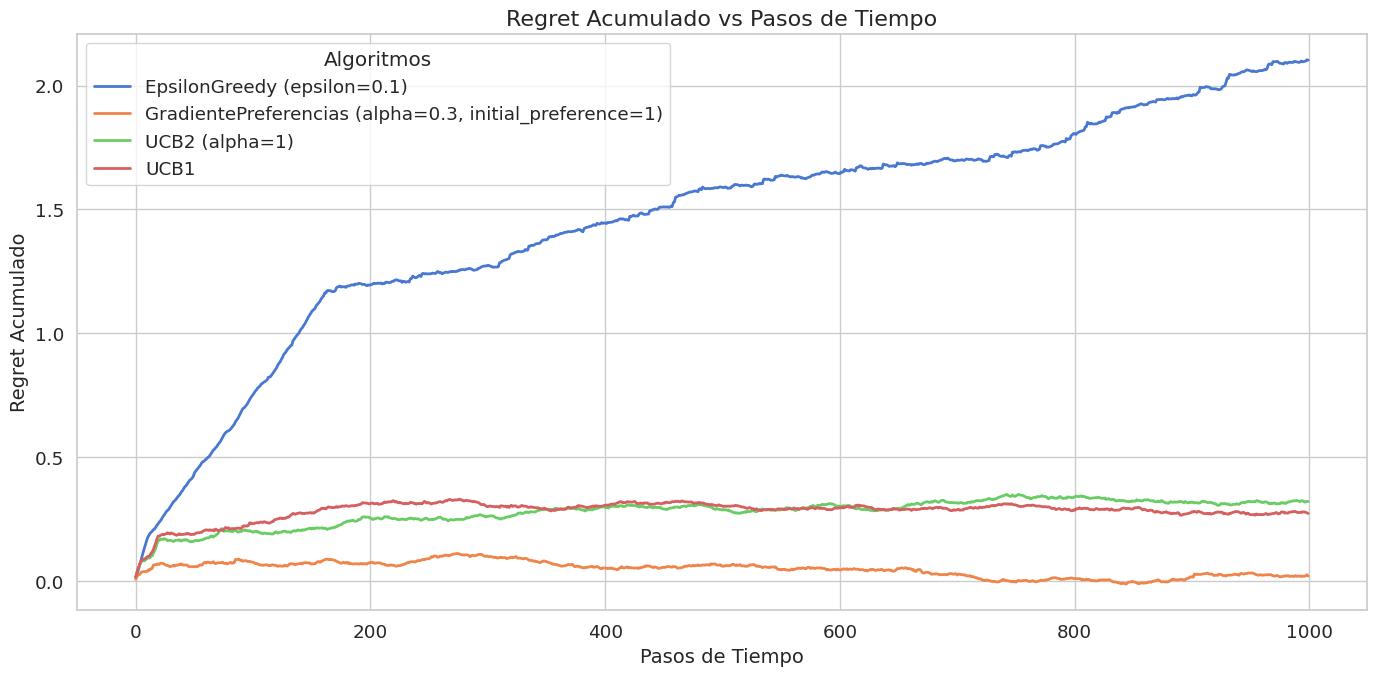

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
  1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Muestra una subida inicial muy pronunciada en el regret acumulado, indicando una exploración inicial ineficiente.
  * En este escenario, Epsilon-Greedy obtiene el peor regret acumulado, sugiriendo que la exploración constante es perjudicial con un mayor número de brazos.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Sorprendentemente, Gradiente de Preferencias muestra el mejor rendimiento en esta métrica, con un regret acumulado muy cercano a 0.
  * Este resultado es notablemente diferente al observado en la gráfica de recompensa promedio, donde Gradiente de Preferencias tenía un rendimiento intermedio.

3. **UCB1 (roja) y UCB2 (verde):**
  * Ambos algoritmos muestran una pequeña subida inicial en el regret acumulado, seguida de una estabilización alrededor de 0.3.
  * Esto muestra que los algoritmos UCB, son muy eficaces minimizando el regret con una cantidad alta de brazos.

**Conclusiones**
  * El aumento en el número de brazos a 20 tiene un impacto significativo en el rendimiento de los algoritmos en términos de regret acumulado.
  * Epsilon-Greedy se ve muy afectado, mostrando un alto regret acumulado.
  * Gradiente de Preferencias muestra un rendimiento excepcional en esta métrica, lo que sugiere que puede ser efectivo para minimizar el regret acumulado en entornos con muchos brazos, a pesar de no maximizar la recompensa promedio de la misma manera.

##### Porcentaje de selección del brazo óptimo

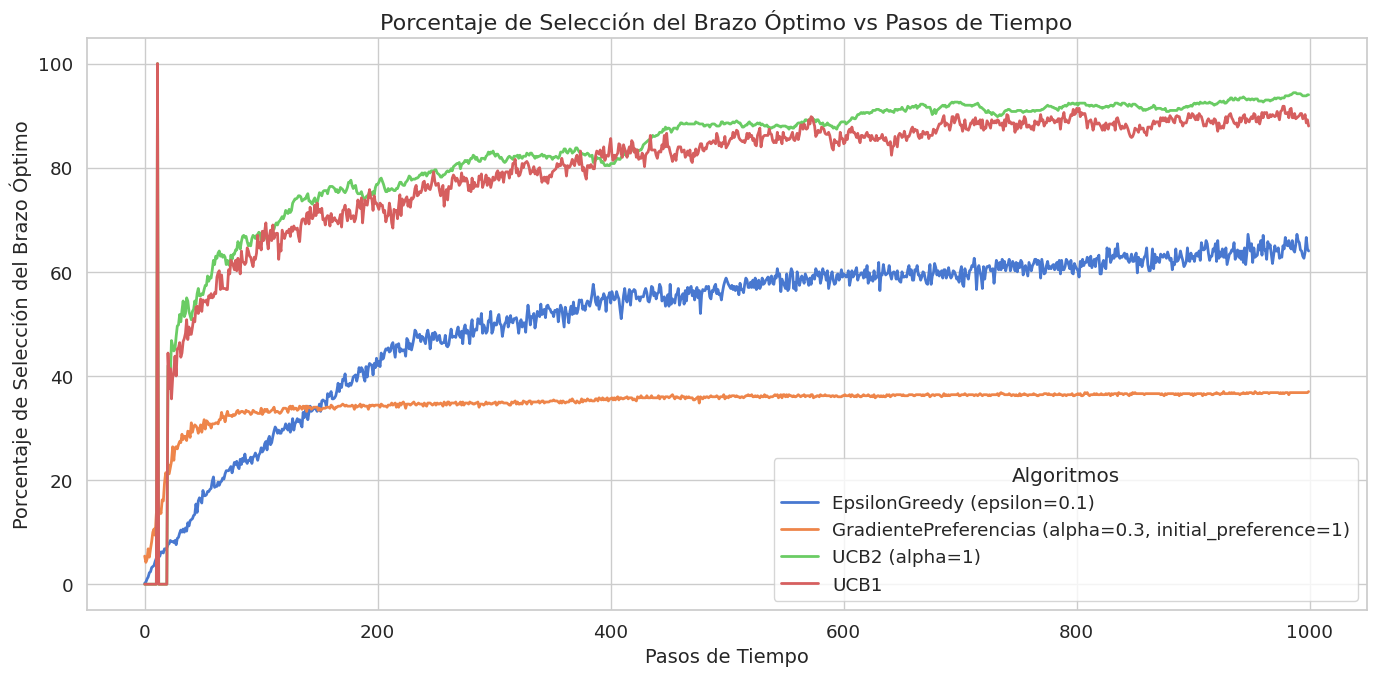

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Observaciones principales**
 1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Tarda bastante en converger, alcanzando un porcentaje de selección del brazo óptimo de alrededor del 60%.
  * Esto refleja la exploración constante de Epsilon-Greedy, que retrasa la explotación óptima.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Muestra una convergencia rápida, pero el porcentaje de selección del brazo óptimo se estabiliza alrededor del 35%.
  * Esto sugiere que, aunque aprende rápidamente, tiene dificultades para explotar la acción óptima de manera consistente.

3. **UCB1 (roja) y UCB2 (verde):**
  * Comienzan con un pico inicial de selección alta, similar al escenario con 10 brazos.
  * Sin embargo, la convergencia es más lenta, tardando aproximadamente 400 pasos de tiempo en alcanzar un porcentaje de selección cercano al 90%.

**Conclusiones**
* El aumento en el número de brazos a 20 afecta significativamente el rendimiento de los algoritmos en términos de selección del brazo óptimo.
* Esta métrica, muestra claramente la dificultad de los algoritmos para explotar el brazo optimo cuando se aumenta la cantidad de brazos.

#### K = 30

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 30  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.3), UCB2(k=k, alpha=1), UCB1(k=k)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 30 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=2.26, sigma=1.0), ArmNormal(mu=5.1, sigma=1.0), ArmNormal(mu=6.33, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=2.8, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=3.63, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=4.3, sigma=1.0), ArmNormal(mu=5.63, sigma=1.0), ArmNormal(mu=6.47, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0), ArmNormal(mu=1.42, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

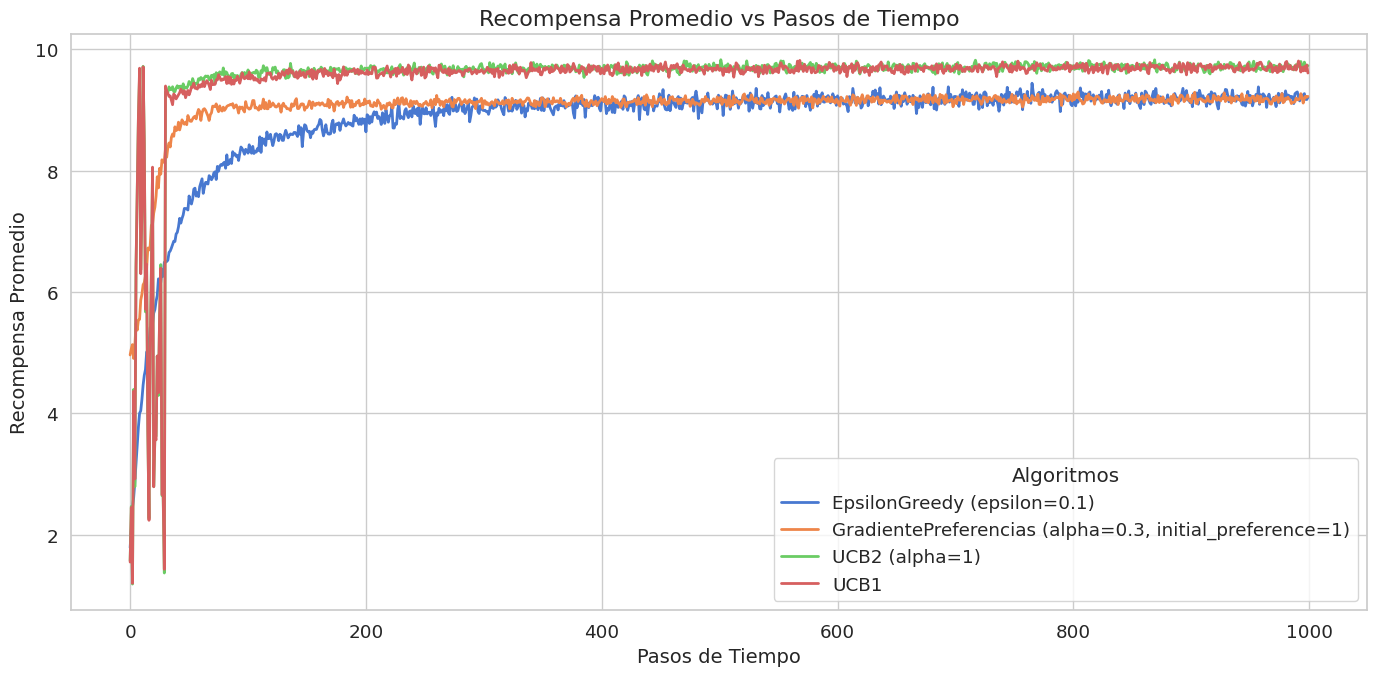

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * El comportamiento se mantiene consistente, aunque la convergencia es ligeramente más lenta que en los escenarios con menos brazos.
  * La recompensa promedio alcanzada permanece relativamente baja, lo que indica que la exploración constante sigue siendo un factor limitante.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Similar a Epsilon-Greedy, la convergencia es un poco más lenta, pero el comportamiento general se mantiene.

3. **UCB1 (roja) y UCB2 (verde):**
  * El período de exploración inicial y la volatilidad en la recompensa promedio aumentan significativamente.
  * Las oscilaciones en la recompensa promedio son más pronunciadas y frecuentes, lo que refleja la mayor dificultad para explorar un espacio de acción más grande.
  * Esto demuestra la capacidad de los algoritmos UCB para adaptarse a entornos con mayor complejidad, aunque requieren un período de exploración inicial más extenso.

**Conclusiones**
  * El aumento en el número de brazos a 30 intensifica el efecto observado en el escenario con 20 brazos, especialmente para los algoritmos UCB.
  * A pesar de los desafíos adicionales, UCB1 y UCB2 siguen demostrando su capacidad para maximizar la recompensa en entornos complejos.
  * Epsilon-Greedy y Gradiente de Preferencias mantienen un comportamiento relativamente constante, lo que sugiere que su rendimiento es menos sensible al número de brazos en este rango.

##### Regret acumulado

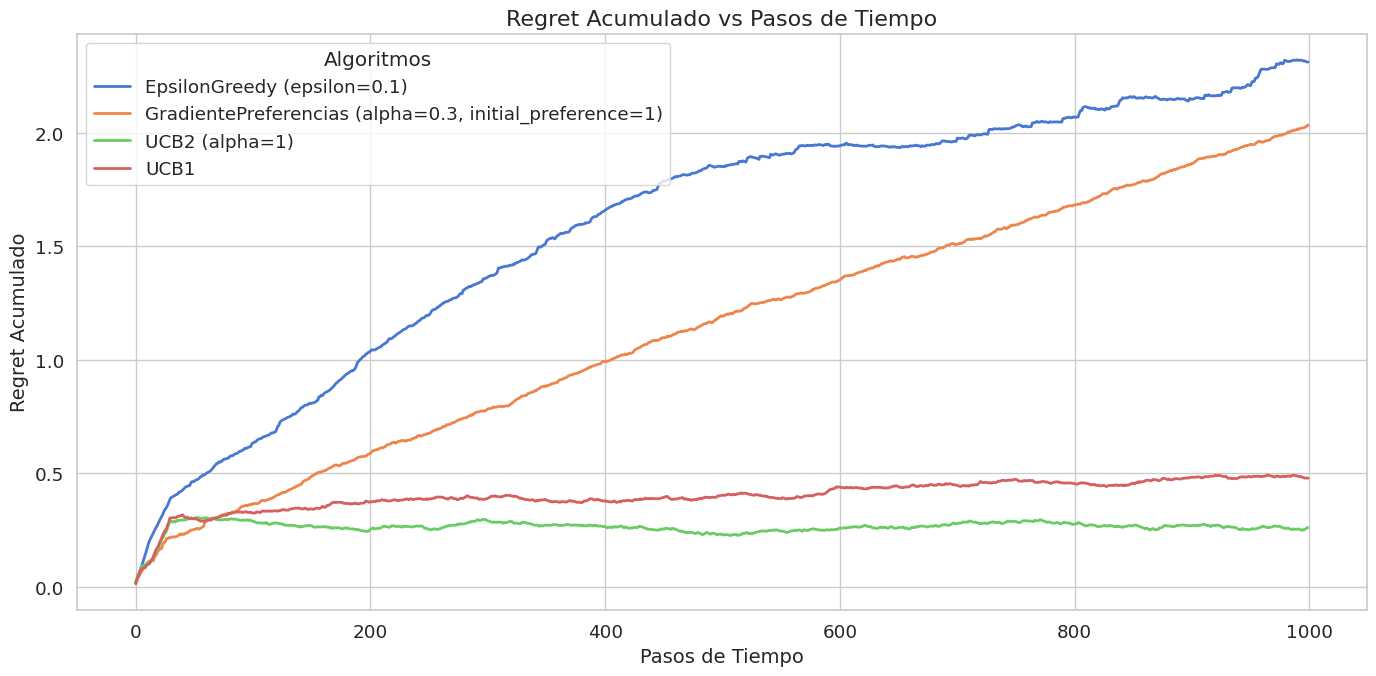

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
  1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Muestra un regret acumulado que crece casi linealmente, indicando un rendimiento muy deficiente.
  * Con 30 brazos, la exploración constante de Epsilon-Greedy resulta en una pérdida acumulada significativa, ya que el algoritmo tiene dificultades para converger a la acción óptima.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * También muestra un regret acumulado que crece casi linealmente, aunque ligeramente mejor que Epsilon-Greedy.
  * La dificultad para adaptarse a un gran número de brazos se refleja en la alta pérdida acumulada.

3. **UCB1 (roja) y UCB2 (verde):**
  * Ambos algoritmos muestran un patrón similar: una pequeña subida inicial en el regret acumulado, seguida de una estabilización alrededor de 0.5.
  * Esto muestra que los algoritmos UCB, son muy eficaces minimizando el regret con una cantidad alta de brazos.

  * Es posible que los cambios en el brazo óptimo entre los experimentos hayan influido en el comportamiento de Gradiente de Preferencias.

**Conclusiones**
  * Con 30 brazos, los algoritmos UCB (UCB1 y UCB2) demuestran una vez más su superioridad en términos de regret acumulado.
  * Epsilon-Greedy y Gradiente de Preferencias muestran un rendimiento deficiente, lo que indica que no son adecuados para entornos con un gran número de brazos.

##### Porcentaje de selección del brazo óptimo

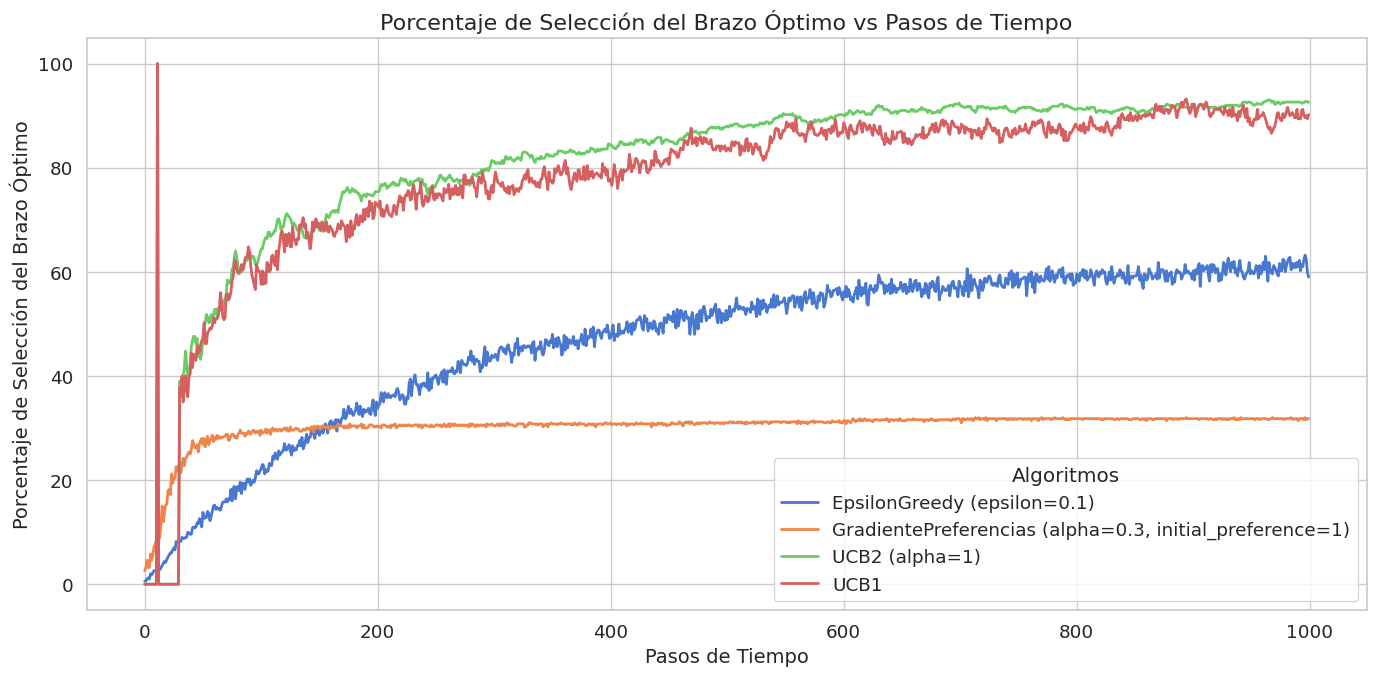

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Observaciones principales**
 1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Tarda bastante en converger, alcanzando un porcentaje de selección del brazo óptimo de alrededor del 60%.
  * Esto refleja la exploración constante de Epsilon-Greedy, que retrasa la explotación óptima.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Continúa mostrando una convergencia rápida, pero el porcentaje de selección del brazo óptimo se mantiene bajo, alrededor del 30%.
  * Esto indica que, con un gran número de brazos, Gradiente de Preferencias tiene dificultades significativas para explotar la acción óptima.

3. **UCB1 (roja) y UCB2 (verde):**
  * Muestran un patrón similar al de 20 brazos, pero la convergencia es aún más lenta.
  * Esto refuerza la tendencia de que, a medida que aumenta el número de brazos, los algoritmos UCB requieren más tiempo para explorar y explotar la acción óptima.

**Conclusiones**
* El aumento a 30 brazos intensifica los desafíos observados en el escenario con 20 brazos.
* Los algoritmos UCB requieren aún más tiempo para converger, pero mantienen un porcentaje de selección relativamente alto.
* Esta métrica, muestra de manera muy clara, la ineficacia de los algoritmos cuando se aumenta la cantidad de brazos.

### Conclusión

Hay un par de observaciones interesantes:

1. El rendimiento del Gradiente de Preferencias en regret acumulado:
  *  Este algoritmo obtiene un regret acumulado bajo, lo que sugiere que minimiza la cantidad de selecciones subóptimas.
  * Sin embargo, su recompensa promedio es intermedia y no selecciona con frecuencia el brazo óptimo, lo que es contradictorio.
  * Posible explicación: En un entorno con muchos brazos, puede estar explorando varias opciones similares en recompensa y nunca enfocándose completamente en la mejor.

2. UCB1 y UCB2 funcionan bien porque balancean exploración y explotación dinámicamente, probando los brazos menos explorados al inicio, pero favoreciendo rápidamente aquellos con alta recompensa promedio.

## Comparación entre distribuciones
El paso final es analizar su comportamiento ante diferentes distribuciones de recompensa.

No se va a analizar la distribución normal ya que saldrían las mismas graficas que obtenidas en el apartado "Comparación entre algoritmos".

#### Distribución binomial

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k, 10)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.3), UCB2(k=k, alpha=1), UCB1(k=k)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=10, p=0.4), ArmBinomial(n=10, p=0.86), ArmBinomial(n=10, p=0.22), ArmBinomial(n=10, p=0.69), ArmBinomial(n=10, p=0.58), ArmBinomial(n=10, p=0.15), ArmBinomial(n=10, p=0.79), ArmBinomial(n=10, p=0.67), ArmBinomial(n=10, p=0.12), ArmBinomial(n=10, p=0.88)
Optimal arm: 10 with expected reward=8.8


##### Recompensa promedio

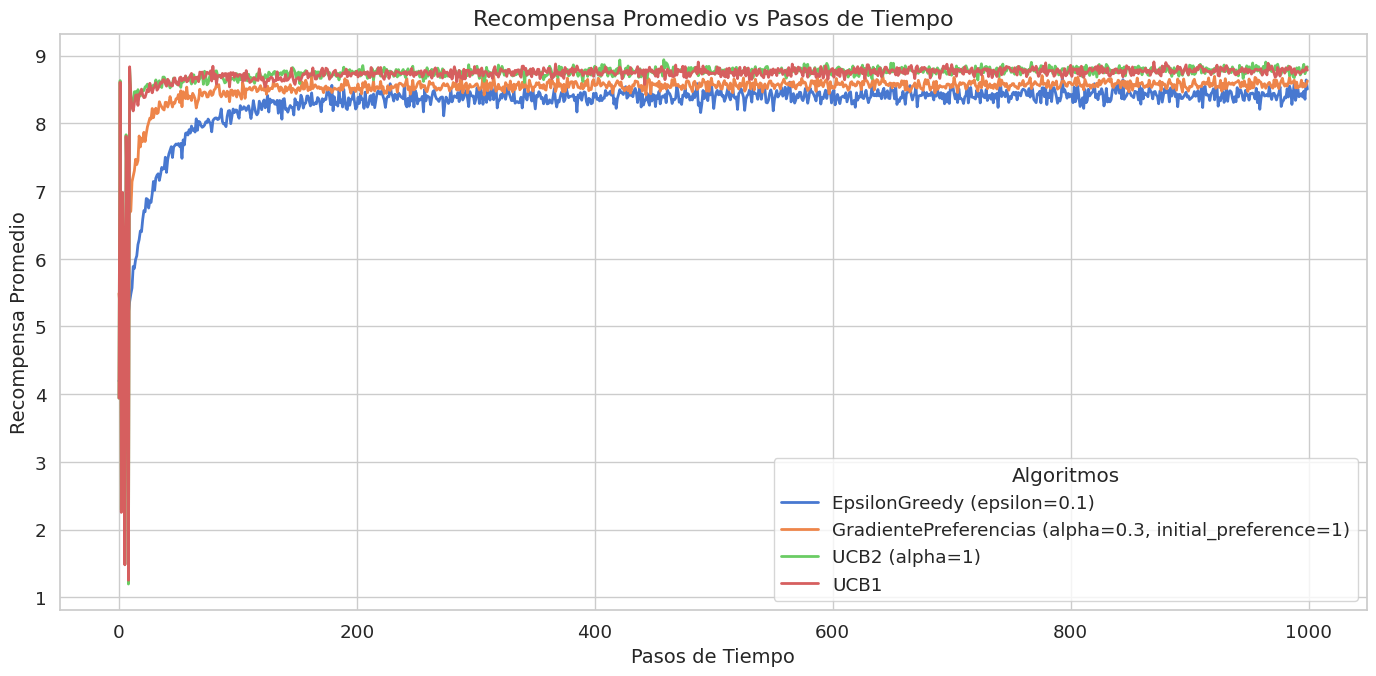

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
   * Se observa que los resultados de los tres algoritmos tienden a acercarse más entre sí en comparación con la distribución normal. Esto sugiere que la distribución binomial puede reducir la variabilidad en el rendimiento de los algoritmos.

1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Sigue siendo el algoritmo con una convergencia más lenta.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Muestra un comportamiento consistente, con una convergencia rápida y una recompensa promedio similar a los escenarios anteriores.

3. **UCB1 (roja) y UCB2 (verde):**
  * El período de oscilación inicial en la recompensa promedio aumenta en comparación con la distribución normal. Esto indica que los algoritmos UCB requieren un período de exploración más prolongado para adaptarse a la distribución binomial.
  * La mayor oscilación al inicio, es debido a que la distribución binomial genera una mayor incertidumbre inicial, lo que provoca que los algoritmos UCB necesiten más tiempo para explorar y explotar de manera efectiva.

**Conclusiones**
  * La distribución binomial influye en el comportamiento de los algoritmos, especialmente en los UCB, aumentando el período de oscilación inicial.
  * A pesar de los cambios, los algoritmos UCB siguen demostrando su capacidad para maximizar la recompensa, aunque con una mayor necesidad de exploración inicial.
  * Los demás algoritmos, muestran una mayor estabilidad frente a este cambio de distribución.

##### Regret acumulado

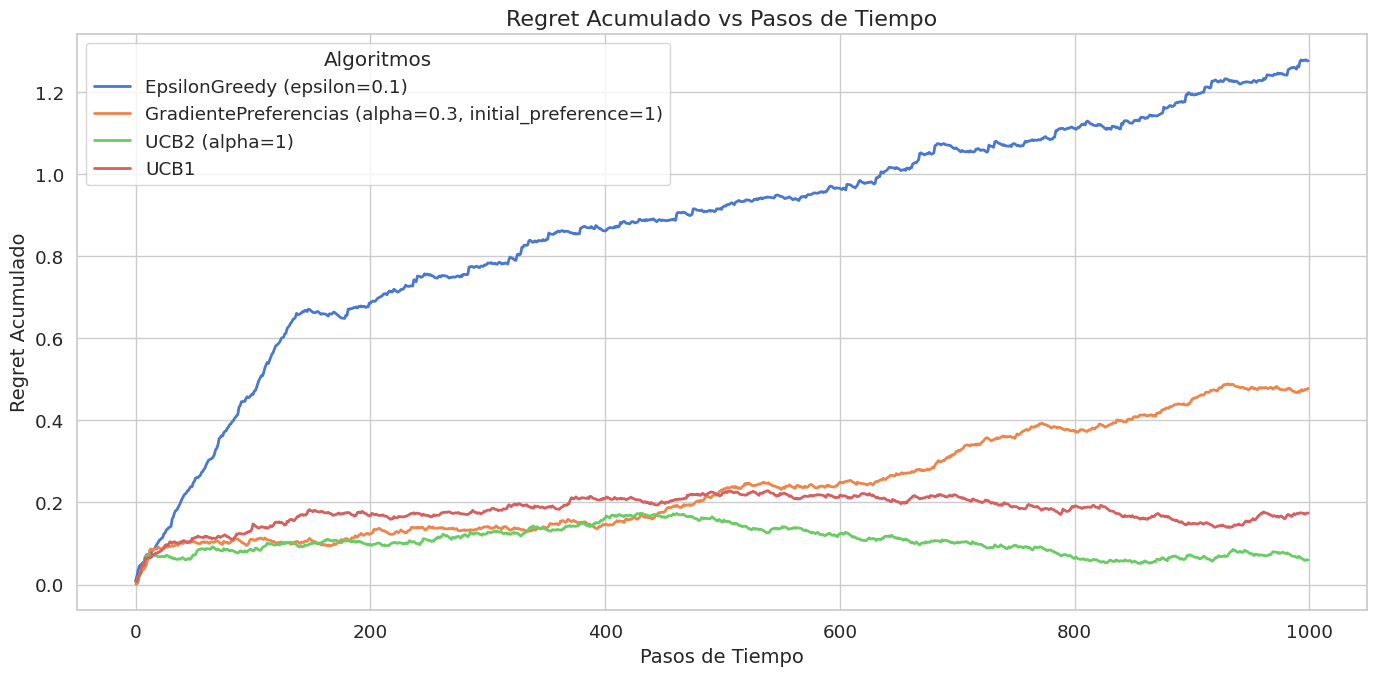

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
  1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Muestra un aumento significativo en el regret acumulado durante las primeras iteraciones, lo que indica una exploración inicial ineficiente.
  * Después de la subida inicial, el regret acumulado se estabiliza un poco, pero sigue aumentando gradualmente.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Muestra un rendimiento cercano al de los algoritmos UCB, aunque ligeramente inferior al final.

3. **UCB1 (roja) y UCB2 (verde):**
  * Ambos algoritmos muestran un rendimiento muy similar, con un regret acumulado bajo y estable.
  * Esto muestra que los algoritmos UCB, son muy eficaces minimizando el regret con una cantidad alta de brazos.

**Conclusiones**
  * Los algoritmos UCB (UCB1 y UCB2) siguen demostrando su superioridad en términos de regret acumulado, incluso con una distribución binomial.
  * Epsilon-Greedy se ve muy afectado, mostrando un alto regret acumulado.
  * Gradiente de Preferencias muestra un rendimiento mejorado en comparación con la distribución normal, lo que sugiere que puede ser más adecuado para entornos con distribuciones discretas.

##### Porcentaje de selección del brazo óptimo

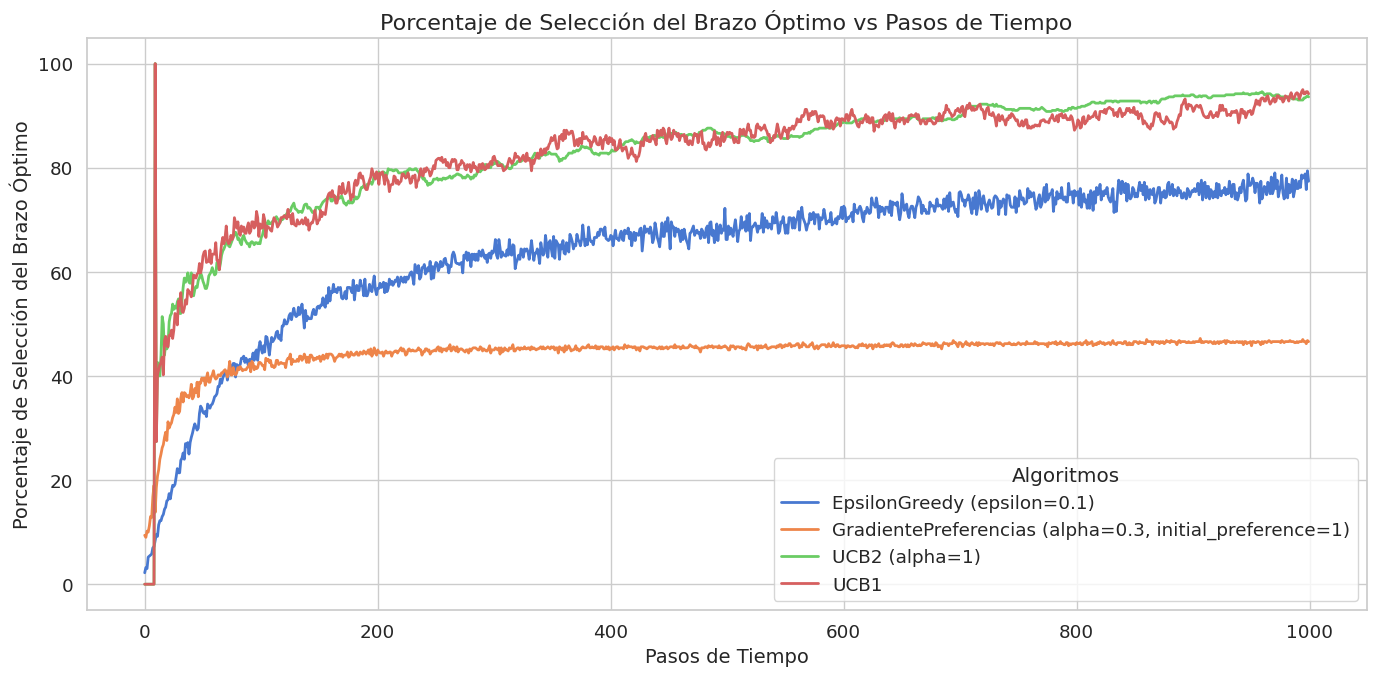

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Observaciones principales**
 1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * También muestra una convergencia más lenta, tardando más o menos lo mismo que UCB para alcanzar un 80% de selección del brazo óptimo.
  * Esto refuerza la idea de que la distribución binomial afecta negativamente la velocidad de convergencia de los algoritmos.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Muestra una convergencia muy rápida, pero se estabiliza en un porcentaje de selección del brazo óptimo de alrededor del 45%.

3. **UCB1 (roja) y UCB2 (verde):**
  * Muestran un comportamiento similar, pero la convergencia es más lenta en comparación con la distribución normal.
  * Tardan más en converger al 90% de selección del brazo óptimo.
  * Esto indica que la distribución binomial introduce una mayor dificultad para la convergencia rápida de los algoritmos UCB.

**Conclusiones**
* La distribución binomial introduce desafíos adicionales para la convergencia de los algoritmos en la selección del brazo óptimo.
* Los algoritmos UCB requieren aún más tiempo para converger, pero mantienen un porcentaje de selección relativamente alto.
* Esta métrica, muestra que la distribucion binomial, afecta de manera muy similar a aumentar la cantidad de brazos.

##### Conclusión

Los algoritmos UCB1 y UCB2 siguen siendo los más efectivos en minimizar el regret acumulado y en converger a una selección más frecuente del brazo óptimo, aunque tardan más en lograrlo debido a la incertidumbre inicial de la distribución binomial.

Sin embargo, si el criterio principal es la velocidad de convergencia, el Gradiente de Preferencias (alpha=0.3) muestra una adaptación más rápida, aunque con un porcentaje final de selección del brazo óptimo más bajo.

La distribución binomial introduce una mayor variabilidad inicial en las recompensas, lo que aumenta la incertidumbre en la fase de exploración. UCB es un algoritmo diseñado para balancear la exploración y la explotación mediante un término de incertidumbre basado en la varianza, lo que le permite manejar esta variabilidad de manera efectiva a largo plazo.

Un punto interesante es que la distribución binomial genera un efecto similar al de aumentar la cantidad de brazos, es decir, los algoritmos tardan más en converger. Esto sugiere que las distribuciones discretas pueden hacer que los algoritmos tomen decisiones más conservadoras en la fase de exploración.

#### Distribución de Bernoulli

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [EpsilonGreedy(k=k, epsilon=0.1), GradientePreferencias(k=k, alpha=0.3), UCB2(k=k, alpha=1), UCB1(k=k)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.4), ArmBernoulli(p=0.86), ArmBernoulli(p=0.22), ArmBernoulli(p=0.69), ArmBernoulli(p=0.58), ArmBernoulli(p=0.15), ArmBernoulli(p=0.79), ArmBernoulli(p=0.67), ArmBernoulli(p=0.12), ArmBernoulli(p=0.88)
Optimal arm: 10 with expected reward=0.88


##### Recompensa promedio

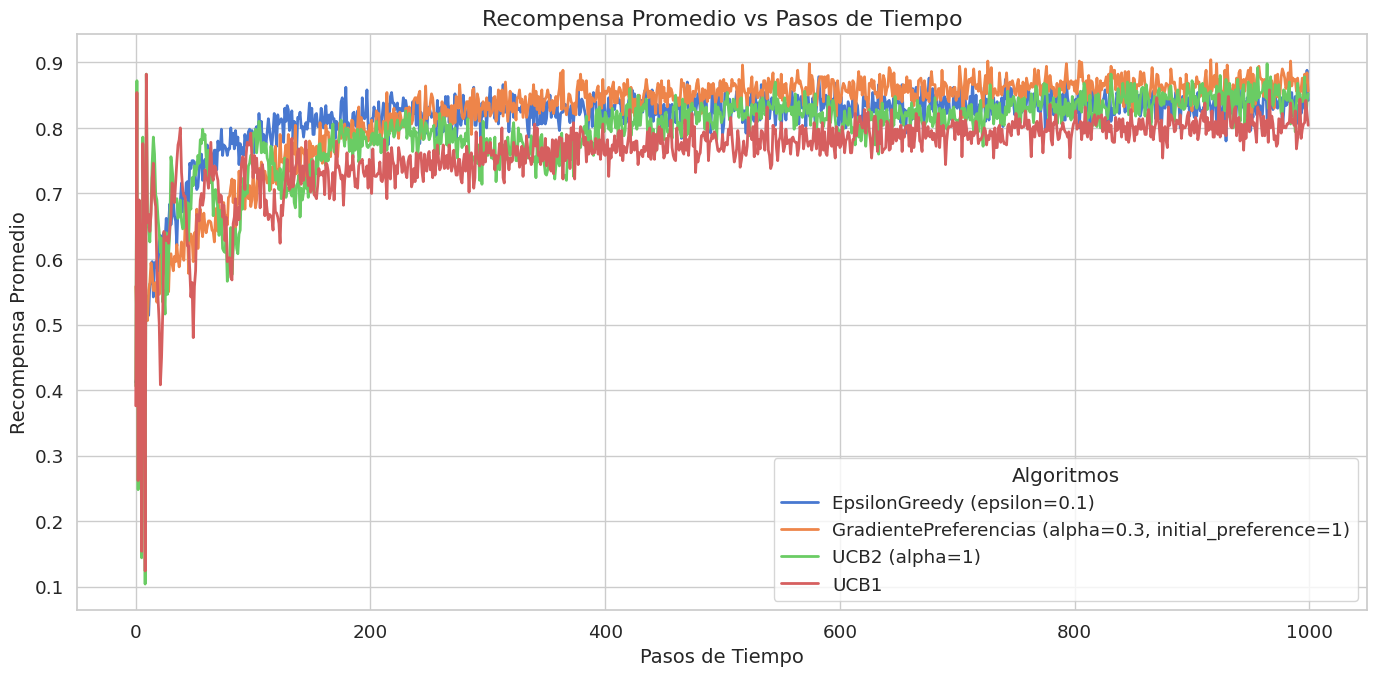

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
   * Se observa que los algoritmos muestran un comportamiento distintivo en comparación con las distribuciones normal y binomial.
   * Alcanza una recompensa promedio alta, lo que indica que la exploración constante es efectiva en este escenario.

1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Muestra un buen rendimiento general, con una convergencia relativamente rápida en comparación con otros algoritmos.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Alcanza la recompensa promedio más alta, pero muestra una convergencia muy lenta.
  * Esto sugiere que la adaptación gradual de las preferencias es efectiva a largo plazo, pero requiere un período de aprendizaje prolongado.

3. **UCB1 (roja) y UCB2 (verde):**
  * Muestran oscilaciones prolongadas a lo largo del tiempo, lo que indica una mayor dificultad para estabilizarse.
  * La recompensa promedio alcanzada es relativamente baja en comparación con otros algoritmos, aunque no significativamente.

**Conclusiones**
  * Epsilon-Greedy muestra un buen equilibrio entre exploración y explotación en este escenario.
  * Gradiente de Preferencias es efectivo a largo plazo, pero requiere un período de aprendizaje extenso.
  * Esta distribución, genera incertidumbre prolongada.

##### Regret acumulado

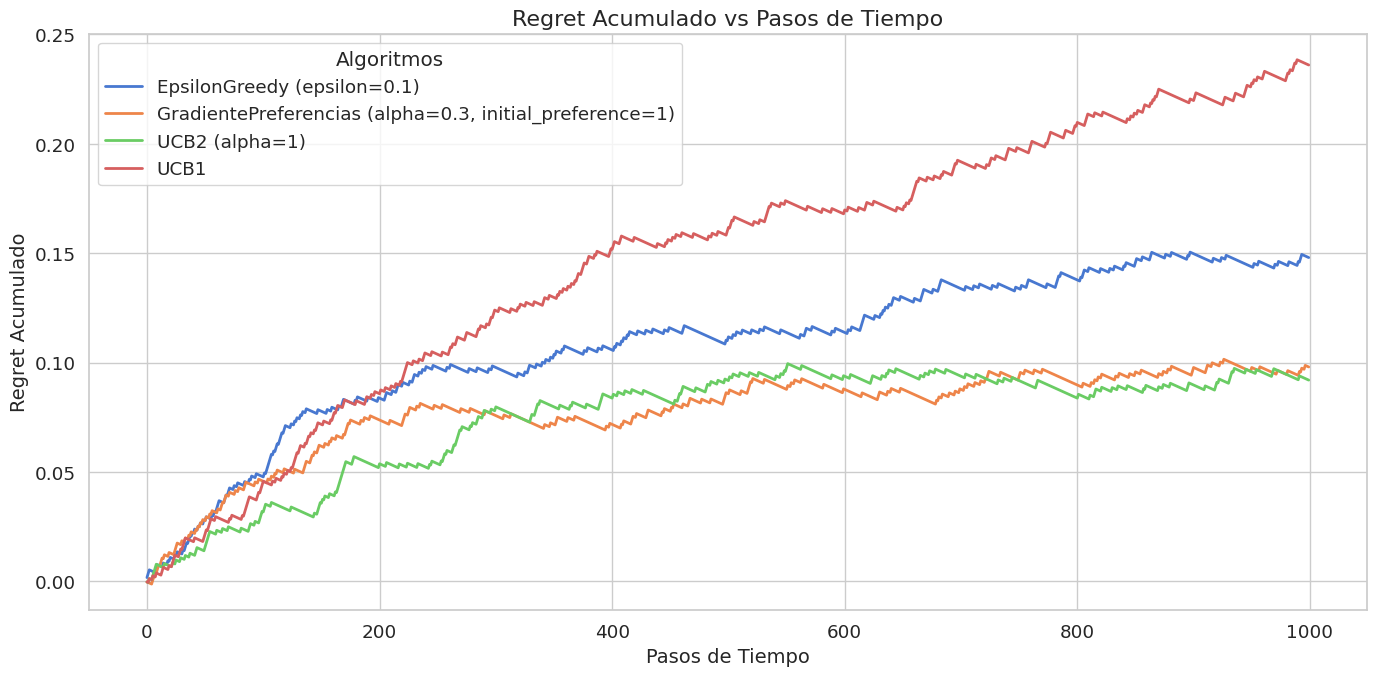

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Análisis del comportamiento**
  1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Muestra un buen desempeño en este tipo de distribución.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Muestra un rendimiento cercano al de los algoritmos UCB, aunque ligeramente inferior al final.
  * Este algoritmo, demuestra ser muy eficaz en distribuciones de bernoulli.

3. **UCB1 (roja) y UCB2 (verde):**
  * En este escenario, UCB1 muestra el peor rendimiento, con un regret acumulado ligeramente superior al de los demás algoritmos.
  * Esto es algo inusual, y puede ser debido a la alta variabilidad de la distribución de bernoulli.

  * La distribución de Bernoulli, al ser una distribución binaria, introduce una alta variabilidad en las recompensas, lo que puede afectar la estabilidad de los algoritmos.

**Conclusiones**
  * En la distribución de Bernoulli, todos los algoritmos muestran un rendimiento similar en términos de regret acumulado.

##### Porcentaje de selección del brazo óptimo

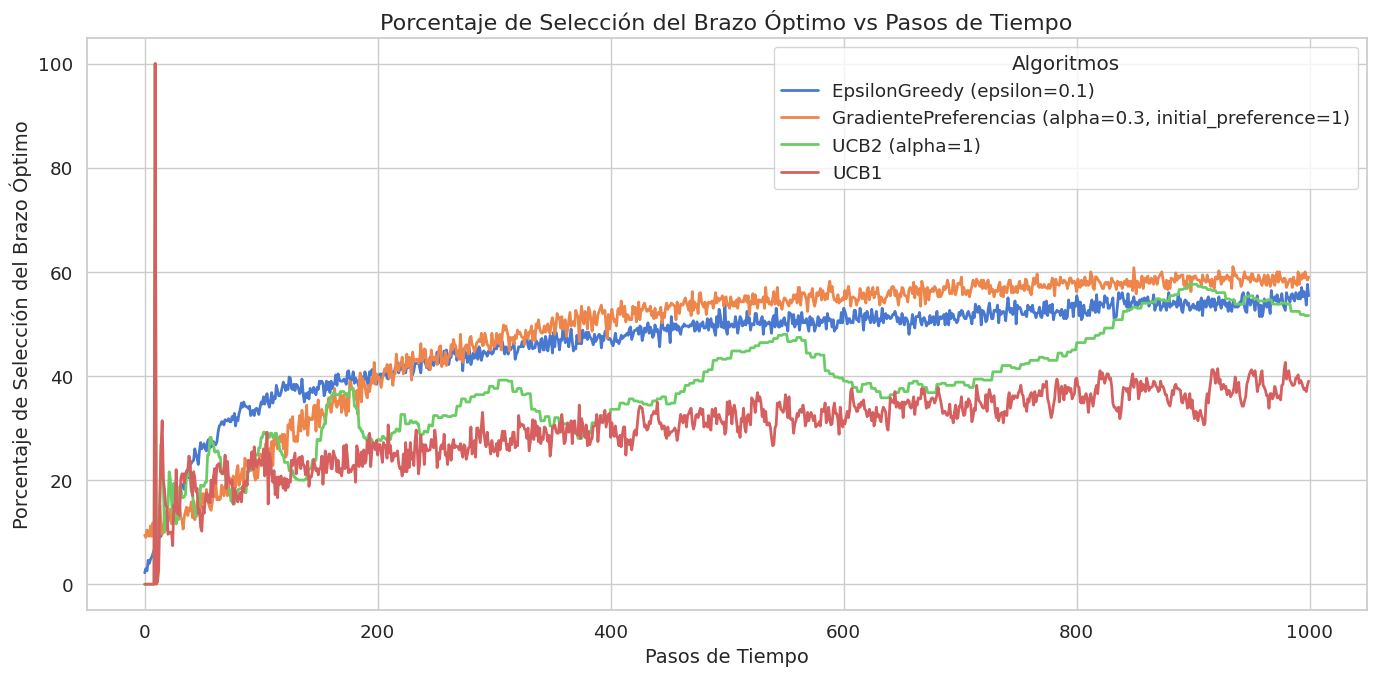

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**:  Cada línea representa un algoritmo diferente:
  * Azul: Epsilon-Greedy (epsilon=0.1)
  * Naranja: Gradiente de Preferencias (alpha=0.3)
  * Roja: UCB1
  * Verde: UCB2 (alpha=1)

**Observaciones principales**
 1. **Epsilon-Greedy (azul, epsilon=0.1):**
  * Muestra un crecimiento más rápido al inicio en comparación con Gradiente de Preferencias.
  * Muestra un crecimiento más rápido al inicio en comparación con Gradiente de Preferencias.

2. **Gradiente de Preferencias (naranja, alpha=0.3):**
  * Muestra el porcentaje de selección del brazo óptimo más alto, alcanzando aproximadamente el 60%.
  * Este algoritmo, es el más eficaz en este tipo de distribución.

3. **UCB1 (roja):**
  * Muestra una alta variabilidad al principio, lo que indica dificultades iniciales para identificar y explotar el brazo óptimo.
  * Después de la variabilidad inicial, se estabiliza alrededor del 40-50% de selección del brazo óptimo.

4. **UCB2 (verde):**
  * Muestra variabilidad a lo largo de todo el proceso, lo que sugiere una dificultad constante para mantener una selección estable del brazo óptimo.

**Conclusiones**
* La distribución de Bernoulli introduce una alta variabilidad que dificulta la selección estable del brazo óptimo, especialmente para los algoritmos UCB.
* Gradiente de Preferencias muestra un mejor rendimiento en esta distribución, aunque con una convergencia lenta.
* Esta métrica, muestra una vez más, que la distribución de Bernoulli, genera un entorno muy distinto a las demás distribuciones.

##### Conclusión

En términos generales, el Gradiente de Preferencias (alpha=0.3) se desempeña mejor en la distribución de Bernoulli. Aunque su convergencia es más lenta, logra la mayor recompensa promedio y la mayor selección del brazo óptimo a largo plazo. Esto sugiere que este método, al actualizar gradualmente las preferencias, es más adecuado para este tipo de distribución con alta variabilidad.

Por otro lado, Epsilon-Greedy (epsilon=0.1) también funciona sorprendentemente bien, mostrando un balance adecuado entre exploración y explotación en este entorno. Su desempeño en regret acumulado es sólido y su tasa de selección del brazo óptimo es competitiva.

Los algoritmos UCB1 y UCB2 tienen dificultades en esta distribución, mostrando oscilaciones prolongadas y menor estabilidad en la selección del brazo óptimo. UCB1, en particular, tiene el peor rendimiento en términos de regret acumulado, lo cual es un resultado inesperado, ya que suele destacar en otros escenarios.

# Conclusiones finales

Los algoritmo **UCB demuestran un rendimiento superior** en la mayoría de los escenarios. Son muy eficaces en entornos con un gran número de brazos, aunque requieren un período de exploración inicial más prolongado.

En cuanto a **Gradiente de Preferencias, muestra un rendimiento variable**, dependiendo de la métrica y la distribución de recompensa. En algunos escenarios, como con la distribución de Bernoulli, puede superar a otros algoritmos.

Por último, Epsilon-Greedy es un algoritmo simple y efectivo, pero puede ser lento para converger, especialmente con un gran número de brazos. Además, la exploración constante puede limitar su capacidad para maximizar la recompensa en algunos escenarios.

Eso sería un resumen general, pero la elección del algoritmo depende del contexto específico:
* **Distribución normal y binomial**:
  * UCB1 o UCB2 son las mejores opciones en general, debido a su capacidad para maximizar la recompensa y minimizar el regret.
  * En la distribución binomial convergen un poco más lento.
* **Distribución de Bernoulli**:
  * Gradiente de Preferencias muestra un rendimiento destacado, especialmente en la selección del brazo óptimo.
  * Epsilon-Greedy tambien se comporta mejor que con la distribución normal.
* **Aumento de la complejidad del problema**:
  * Los algoritmos UCB son los más robustos y eficaces en entornos con muchos brazos.
  * Epsilon-Greedy y Gradiente de Preferencias pueden tener dificultades para converger y maximizar la recompensa.